# Logistic Regression

Logistic Regression is a popular technique for Classification problems. This model uses the sigmoid function to calculate the posterior probability of a Class.

Here, the predictions of Logistic Regression are in the form of probabilities of an event occurring, (i.e., the probability of binary classes), given certain attribute values of input variables x.

- The underlying formula for classification of the perceptron algorithm is given by:
    - $\hat{y} = \sigma(w^{T}\phi(x))$, where 
        - $\\sigma(n) = \frac{1}{1+e^{-n}}$ is the sigmoid or logistic function.

- The vector $w$ is obtained by training on a dataset for some iterations using gradient descent or its variants like stochastic Gradient Descent or Mini Batch Gradient Descent.

- The update of w for every misclassified point is then given by: 
   - $w^{\tau + 1} = w^{\tau} + \eta.▽(\sigma(w^{T}\phi(x)))$, 
    - where $\\eta$ is the learning rate,
    - ${w}$ is the weight matrix.
    - $\\phi(x)$ is a transformed feature,
    - The value of the gradient/partial derivative (▽) is given by:
        - $(\hat{y} - y).\hat{y}.(1-\hat{y})$
        - here $y$ is the true value and $\hat{y}=\\sigma(n) = \frac{1}{1+e^{-n}}$ is the predicted value (given by sigma function) for a data point .

## Implementation
- The algorithm uses NumPy,pandas and matplotlib as dependencies
- The training and testing data are vectorized using NumPy to generate predictions without explicit for loops
- The dataset is shuffled to give 10 shuffled datasets. Each of these are split into 70:30, training and testing splits respectively
- For **Grandient Descent Learning** we have choosen three combinations of learning rates and epochs (iterations) to get the best accuracy.
    - In gradient descent we have trained the model on each of the 10 splits and plotted the accuracies and losses. 
    - Also the average test metrics are displayed.
- Later, the same learning rates (but different epochs) were used to train the model using **Stochastic Gradient Descent**.

**Note**: All of the above implementation is present in the 'LogReg' class. Training the shuffled splits has been done later using the 'LogReg' class.

## Imports

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import os
import tqdm
from tqdm import notebook

## Loading Data

In [59]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [60]:
PARENT = '/gdrive/MyDrive/Projects/ML_Models/'

In [61]:
%cd /gdrive/MyDrive/Projects/ML_Models/

/gdrive/MyDrive/Projects/ML_Models


In [62]:
df =  pd.read_csv('dataset_LR.csv')

In [63]:
df.head()

,attr1,attr2,attr3,attr4,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


## Model

In [64]:
class LogReg():

    def __init__(self, df, standardize=False, train_size=0.7, randomize=True):
        self.w = None
        self.b = None
        self.df = df
        self.train_size = train_size
        self.randomize = randomize
        self.standardize = standardize
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split()
        if standardize:
            self.standard()
        self.accuracyList =[]
        self.lossList =[]
        self.attrList=[]
        self.tAccuracy=[]
    
    def train_test_split(self):
        '''
        Randomizes the data and Splits the data points into training and testing values in the ratio given.
        '''
        data = np.array(self.df)
        train_size=self.train_size
        
        if self.randomize:
            np.random.shuffle(data)

        X = data[:,:-1]
        y = data[:,-1]

        train = int(train_size * X.shape[0])
        test = int((1-train_size) * X.shape[0])

        X_train = X[0 : train]
        X_test = X[train : train+test] 
        y_train = y[0 : train]
        y_test = y[train : train+test] 

        return X_train, X_test, y_train, y_test

    def standard(self):
        '''
        Normalizes the Data the given data.
        '''
        self.X_train = (self.X_train - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)
        self.X_test = (self.X_test - self.X_train.mean(axis=0)) / self.X_train.std(axis=0)  
  
    def perceptron(self, X):
        '''
        Evaluates the linear combination of the weights and the training data.
        Parameters:
            X: Training Point
        '''
        return np.dot(X, self.w.T) + self.b

    def sigmoid(self, X):
        '''
        Sigmoid Function.
        Parameters:
            X: Training Point
        '''
        return 1.0 / (1.0 + np.exp(-X))

    def grad_w(self, x, y):
        '''
        Calculates the gradient of the weight values.
        Parameters:
            x: Training point
            y:  
        '''
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
  
    def grad_b(self, x, y):
        '''
        Calculates the gradient of x_0 value.
        Parameters:
            x: 
            y: 
        '''
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)

    def mean_squared_error(self, y_pred, y):
        '''
        Evaluates the Mean Squared error of the predicted values by comparing it with the true values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        return sum([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])/len([(y1-y2)**2 for y1, y2 in zip(y, y_pred)])
    
    def accuracy(self, y_pred, y):
        '''
        Calculates the accuracy score of the predicted values.
        Parameters:
            y_pred: Predicted values.
            y: True output values.
        '''
        correct = 0
        for i in range(y.shape[0]):
            if y_pred[i]>0.5:
                yp=1
            else:
                yp=0
            if y[i] == yp:
                correct += 1
        return correct / float(y.shape[0])

    def fit(self, X, Y, epochs = 1, learning='GD', learning_rate = 1, batch_size=1, intialize = False, display_loss=False, printValues=True):
        '''
        Trains the model either using Gradient Descent or Stochastic Gradient Descent.
        Parameters:
            X: testing sample
        '''
    
        #intialize
        if intialize:
            self.w = np.random.randn(1, X.shape[1])
            self.b = 0

        if display_loss:
            loss={}
            accuracy={}
        
        count=0

        for i in tqdm.notebook.tqdm(range(epochs), total=epochs, unit="epoch"):
            dw = 0
            db = 0

            if learning == 'GD':
                for x, y in zip(X, Y):
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * (dw/X.shape[0])
                self.b -= learning_rate * (db/X.shape[0])

            if learning == 'SGD':
                # for j in range(X.shape[0]):
                randInt = np.random.randint(0,X.shape[0])
                x = X[randInt, :]
                y = Y[randInt]
                dw += self.grad_w(x,y)
                db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if learning == 'MBSGD':
                randInt = np.arange(0, X.shape[0], batch_size)
                np.random.shuffle(randInt)
                for j in range(randInt.shape[0]):
                    x = X[randInt[j], :]
                    y = Y[randInt[j]]
                    dw += self.grad_w(x,y)
                    db += self.grad_b(x,y)
                self.w -= learning_rate * dw
                self.b -= learning_rate * db

            if display_loss:
                Y_pred = self.sigmoid(self.perceptron(X))
                loss[i] = self.mean_squared_error(Y_pred,Y)[0]
                accuracy[i] = self.accuracy(Y_pred,Y)
                if printValues and i%50==0:
                    print('Epoch:', i,'Loss:', loss[i],'Accuracy:', accuracy[i])

        if display_loss and count%50==0:
            plt.subplot(2, 1, 1)
            plt.plot(list(loss.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Mean Squared Error')

            plt.subplot(2, 1, 2)
            plt.plot(list(accuracy.values()))
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            
            plt.show()
        count=count+1

        self.attrList += [np.argmax(self.w)+1]
        self.lossList += [loss[epochs-1]]
        self.accuracyList += [accuracy[epochs-1]]

    def predict(self, X):
        '''
        Evaluates the sigmoid function value of the given data.
        Parameters:
            X: testing sample
        '''
        # Y_pred = []
        # for x in X:
        #     y_pred = self.sigmoid(self.perceptron(x))
        #     Y_pred.append(y_pred)
        return self.sigmoid(self.perceptron(X))
    
    def binarize(self, X, threshold=0.5):
        '''
        Evaluates the binary labels of the given data.
        Parameters:
            X: testing sample
        '''
        y_pred = self.predict(X)
        Y_p = []
        for y in range(y_pred.shape[0]):
            if y_pred[y]>threshold:
                Y_p+=[1]
            else:
                Y_p+=[0]
        return np.array(Y_p)

    def evaluate(self, x_test, y_test, display_confusion_matrix=True):
        '''
        Evaluates the model for a given testing data
        Parameters:
            x_test: testing samples
            y_test: testing labels
        '''

        y_pred = self.binarize(x_test)
        dict = self.report(y_pred, y_test)
        print('Classification Report') 
        n = np.array(list(dict.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        if display_confusion_matrix:
            self.confusion_matrix(dict)

    def train_k_splits(self, k, epochs=2000, learning = 'GD', learning_rate=0.015, batch_size=1, printVal=True):
        '''
        Performs k-fold validation on the given data.  
        Parameters:
            data
            k: No. of folds
        '''
        
        TP, TN, FP, FN, Total, accuracy, recall, precision=0, 0, 0, 0, 0, 0, 0, 0

        print('Total of 10 Splits:')        
        for i in range(k):

            print()            
            print('Split', i+1,': ')
            X_train, X_test, Y_train, Y_test = self.train_test_split()  
            if self.standardize:
                self.standard()
                
            print('Training the Model...')
            displayLoss=True
            self.fit(X_train, Y_train, epochs, learning=learning, learning_rate=learning_rate , intialize = True, display_loss=displayLoss, batch_size=batch_size, printValues=printVal)
            print()
            print('Trained the Model.')
            print()

            y_pred = self.binarize(X_test)            
            metric_dict = self.report(y_pred, Y_test)
            print('The most important feature is \'attr', np.argmax(self.w)+1, '\'','with weight', self.w[0][np.argmax(self.w)])
            
            TP+=metric_dict['TP']
            TN+=metric_dict['TN']
            FP+=metric_dict['FP']
            FN+=metric_dict['FN']
            Total+=metric_dict['Total']
            accuracy+=metric_dict['Accuracy']
            self.tAccuracy += [metric_dict['Accuracy']]
            precision+=metric_dict['Precision']
            recall+=metric_dict['Recall']
            
            self.evaluate(X_test, Y_test, display_confusion_matrix=False)
            print('Loss : ', self.lossList[i])
        
        avg = {'TP':TP/k, 'TN':TN/k, 'FP':FP/k, 'FN':FN/k, 'Total':Total/k, 'Accuracy':accuracy/k, 'Recall':recall/k, 'Precision':precision/k}
        
        print()
        print()
        print('Final Classification Report (Average Values across ', k, ' splits)') 
        n = np.array(list(avg.items()))
        df = pd.DataFrame(n[:,1], index=n[:,0], columns=[''])
        print(df)
        print('Average Loss : ', np.array(self.lossList).mean())
        print('Most important feature is \'attr', np.argmax(np.bincount(self.attrList)), '\'')
        self.confusion_matrix(avg)
    
    def report(self, y_pred, y_test):
        '''
        calculates precision and recall metrics
        Parameters:
            y_pred: predicted labels on a testing set
            y_test: true labels of the testing set
        '''
        
        TP=0
        TN=0
        FP=0
        FN=0
        Total=len(y_pred)
        for pred, test in zip(y_pred, y_test):
            if pred==test:
                if pred==0:
                    TN+=1
                else:
                    TP+=1
            else:
                if pred==1:
                    FP+=1
                else:
                    FN+=1
        
        accuracy = (TP+TN) / Total
        recall = TP / (TP+FN)
        precision = TP / (TP+FP)
        
        return {'TP':TP, 'TN':TN, 'FP':FP, 'FN':FN, 'Total':Total, 'Accuracy':accuracy, 'Recall':recall, 'Precision':precision}
        
    def confusion_matrix(self, report_val):
        '''
        Plots the confusion Matrix of the given data.
        '''
        
        fig, ax = plt.subplots()
        classes = ['Positive', 'Negitive']
        t = report_val['Total']
        report = np.array([[report_val['TN']/t, report_val['FP']/t], [report_val['FN']/t, report_val['TP']/t]])
        im = ax.imshow(report, cmap = 'Blues')

        ax.set_xticks(np.arange(len(classes)))
        ax.set_yticks(np.arange(len(classes)))

        ax.set_xticklabels(classes)
        ax.set_yticklabels(classes)


        plt.setp(ax.get_xticklabels(), rotation_mode="anchor")
        
        group_names = ['True Neg','False Pos', 'False Neg','True Pos']
        group_percentages = ['{0:.2%}'.format(value) for value in report.flatten()]

        labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)

        for i in range(len(classes)):
            for j in range(len(classes)):
                text = ax.text(j, i, labels[i, j], ha="center", va="center")

        ax.set_title('Confusion Matrix', fontdict = {'size':18}, pad = 20)
        
        fig.tight_layout()
        plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
        plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
        plt.show()

## Gradient Descent

In **Gradient Descent** we iterate over all the $n$ training points and update the weights (matrix) at each point in each epoch of learning. 

The weights are updated in such a way that we minimize the loss, by moving downwards along the gradient to reach the global minima.

Each update is given by:
 - $w^{\tau + 1} = w^{\tau} + \eta.\sum_{i=1}^n{▽(\sigma(w^{T}\phi(x_{n})))}$, 
    - where $\\eta$ is the learning rate,
    - ${w}$ is the weight matrix.
    - $\\phi(x_{n})$ is the transformed feature of the nth data point.
    - The value of the gradient/partial derivative (▽) is given by:
        - $(\hat{y} - y).\hat{y}.(1-\hat{y})$
        , here $\hat{y}=\sigma(w^{T}\phi(x_{n})) = \frac{1}{1+e^{-w^{T}\phi(x_{n})}}$



The model has been trained on the learning rates 0.015, 0.1, and 0.5 using Gradient Decsent.

We have normalized the dataset for 0.1 and 0.5 learning rates. This has given a better accuracy in gradient Descent.

### Learning Rate = 0.015 and Epochs = 5000 - Accuracy = 97.76% - No Normalization

In [65]:
GD = LogReg(df)

Total of 10 Splits:

Split 1 : 
Training the Model...


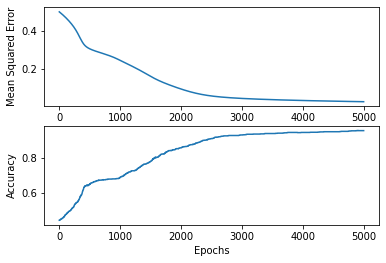


Trained the Model.

The most important feature is 'attr 4 ' with weight -1.0458580202492163
Classification Report
                             
TP                        170
TN                        226
FP                          6
FN                          9
Total                     411
Accuracy   0.9635036496350365
Recall     0.9497206703910615
Precision  0.9659090909090909
Loss :  0.02805118942016982

Split 2 : 
Training the Model...


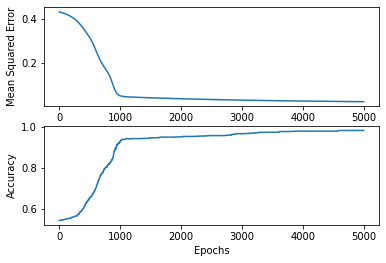


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.17650663087964594
Classification Report
                             
TP                        165
TN                        235
FP                          0
FN                         11
Total                     411
Accuracy   0.9732360097323601
Recall                 0.9375
Precision                 1.0
Loss :  0.020742476177532873

Split 3 : 
Training the Model...


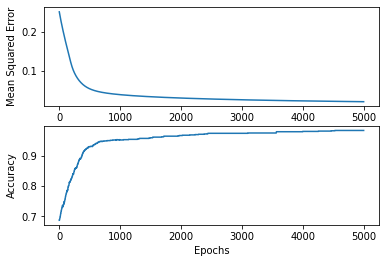


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.33681847291908884
Classification Report
                             
TP                        183
TN                        222
FP                          4
FN                          2
Total                     411
Accuracy   0.9854014598540146
Recall     0.9891891891891892
Precision  0.9786096256684492
Loss :  0.020432912071808595

Split 4 : 
Training the Model...


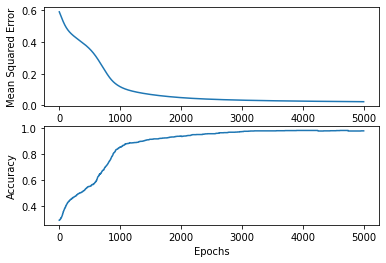


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.1493679207732956
Classification Report
                             
TP                        188
TN                        218
FP                          2
FN                          3
Total                     411
Accuracy   0.9878345498783455
Recall     0.9842931937172775
Precision  0.9894736842105263
Loss :  0.02388858377825911

Split 5 : 
Training the Model...


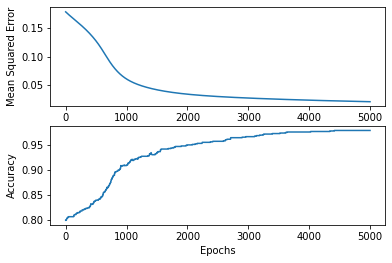


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.27450754434497726
Classification Report
                             
TP                        174
TN                        230
FP                          0
FN                          7
Total                     411
Accuracy   0.9829683698296837
Recall     0.9613259668508287
Precision                 1.0
Loss :  0.020712746704662905

Split 6 : 
Training the Model...


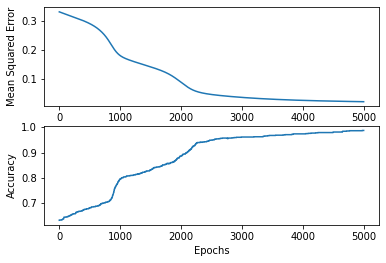


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.02155808273848714
Classification Report
                             
TP                        179
TN                        227
FP                          0
FN                          5
Total                     411
Accuracy   0.9878345498783455
Recall     0.9728260869565217
Precision                 1.0
Loss :  0.020763804785255677

Split 7 : 
Training the Model...


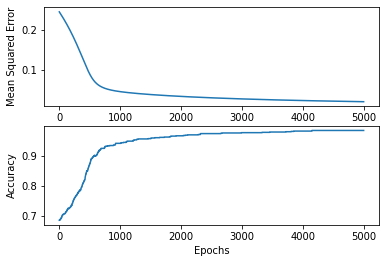


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.21588452331952207
Classification Report
                             
TP                        181
TN                        221
FP                          5
FN                          4
Total                     411
Accuracy   0.9781021897810219
Recall     0.9783783783783784
Precision  0.9731182795698925
Loss :  0.02169186303236764

Split 8 : 
Training the Model...


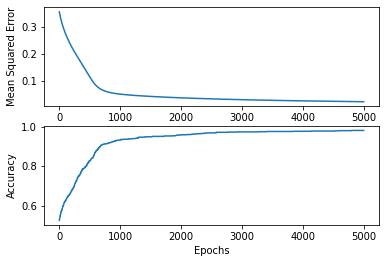


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.23393036829813385
Classification Report
                             
TP                        177
TN                        225
FP                          4
FN                          5
Total                     411
Accuracy   0.9781021897810219
Recall     0.9725274725274725
Precision  0.9779005524861878
Loss :  0.022485293550262037

Split 9 : 
Training the Model...


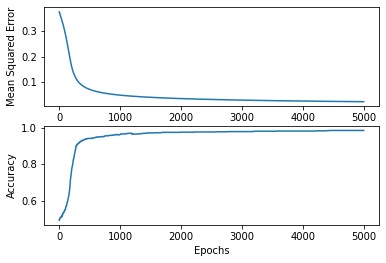


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.15799981194349103
Classification Report
                             
TP                        180
TN                        226
FP                          3
FN                          2
Total                     411
Accuracy   0.9878345498783455
Recall      0.989010989010989
Precision  0.9836065573770492
Loss :  0.021548446489032015

Split 10 : 
Training the Model...


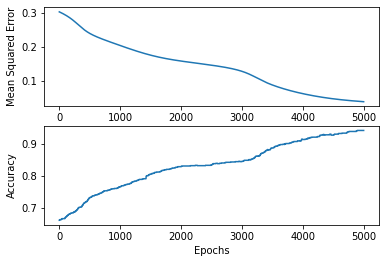


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.23189970073413807
Classification Report
                             
TP                        173
TN                        218
FP                          4
FN                         16
Total                     411
Accuracy   0.9513381995133819
Recall     0.9153439153439153
Precision  0.9774011299435028
Loss :  0.03782432219621237


Final Classification Report (Average Values across  10  splits)
                             
TP                      177.0
TN                      224.8
FP                        2.8
FN                        6.4
Total                   411.0
Accuracy   0.9776155717761557
Recall     0.9650115862365635
Precision  0.9846018920164697
Average Loss :  0.023814163820556306
Most important feature is 'attr 4 '


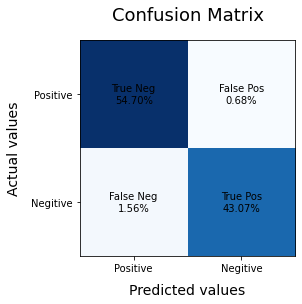

In [66]:
GD.train_k_splits(10, epochs=5000, learning_rate=0.015, printVal=False)

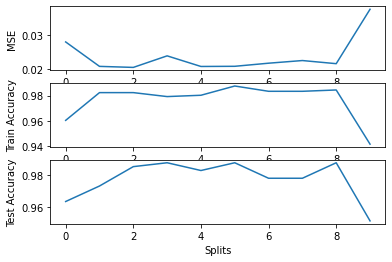

In [68]:
plt.subplot(3, 1, 1)
plt.plot(GD.lossList[:10])
plt.xlabel('Splits')
plt.ylabel('MSE')

plt.subplot(3, 1, 2)
plt.plot(GD.accuracyList[:10])
plt.xlabel('Splits')
plt.ylabel('Train Accuracy')

plt.subplot(3, 1, 3)
plt.plot(GD.tAccuracy[:10])
plt.xlabel('Splits')
plt.ylabel('Test Accuracy')

plt.show()

### Learning Rate = 0.1 and Epochs = 1000 - Accuracy = 97.37% - Normalized

In [ ]:
GD1 = LogReg(df, standardize=True)

Total of 10 Splits:

Split 1 : 
Training the Model...


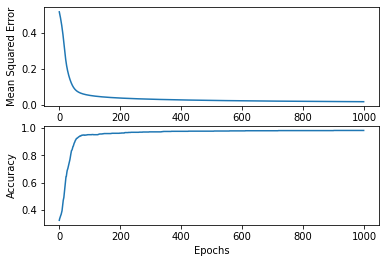


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.2051830284322597
Classification Report
                             
TP                        174
TN                        234
FP                          1
FN                          2
Total                     411
Accuracy   0.9927007299270073
Recall     0.9886363636363636
Precision  0.9942857142857143
Loss :  0.01538459726487873

Split 2 : 
Training the Model...


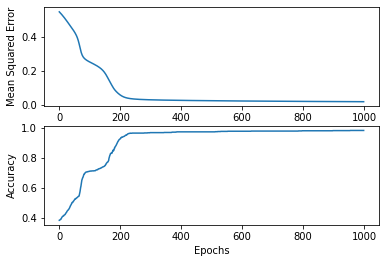


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.24270650088840867
Classification Report
                             
TP                        184
TN                        222
FP                          2
FN                          3
Total                     411
Accuracy   0.9878345498783455
Recall      0.983957219251337
Precision   0.989247311827957
Loss :  0.018471843849633646

Split 3 : 
Training the Model...


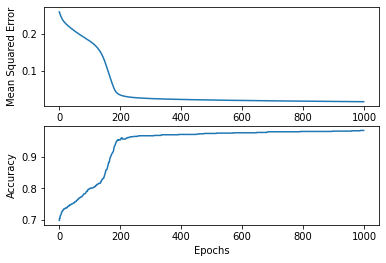


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.351787006478518
Classification Report
                             
TP                        177
TN                        227
FP                          2
FN                          5
Total                     411
Accuracy   0.9829683698296837
Recall     0.9725274725274725
Precision  0.9888268156424581
Loss :  0.017425970336899146

Split 4 : 
Training the Model...


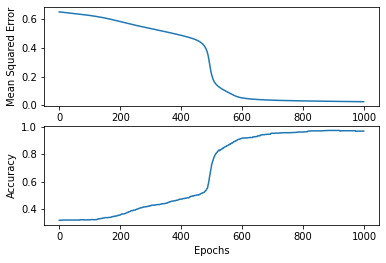


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.23236868464321747
Classification Report
                             
TP                        170
TN                        233
FP                          2
FN                          6
Total                     411
Accuracy   0.9805352798053528
Recall     0.9659090909090909
Precision  0.9883720930232558
Loss :  0.01626747504982501

Split 5 : 
Training the Model...


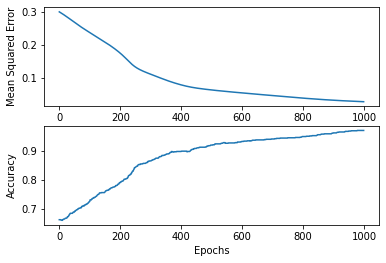


Trained the Model.

The most important feature is 'attr 4 ' with weight 0.07379100560289195
Classification Report
                             
TP                        177
TN                        216
FP                          3
FN                         15
Total                     411
Accuracy   0.9562043795620438
Recall               0.921875
Precision  0.9833333333333333
Loss :  0.025569001386472303

Split 6 : 
Training the Model...


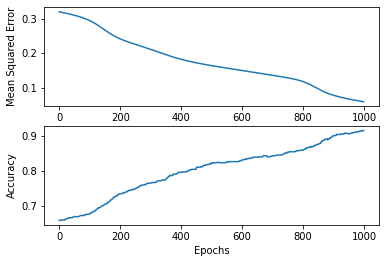


Trained the Model.

The most important feature is 'attr 3 ' with weight -0.5708424301548597
Classification Report
                             
TP                        153
TN                        222
FP                         11
FN                         25
Total                     411
Accuracy   0.9124087591240876
Recall     0.8595505617977528
Precision  0.9329268292682927
Loss :  0.02618668921868415

Split 7 : 
Training the Model...


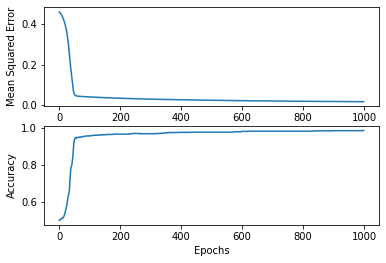


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.18444285338235528
Classification Report
                             
TP                        176
TN                        227
FP                          6
FN                          2
Total                     411
Accuracy   0.9805352798053528
Recall     0.9887640449438202
Precision   0.967032967032967
Loss :  0.061488747945488566

Split 8 : 
Training the Model...


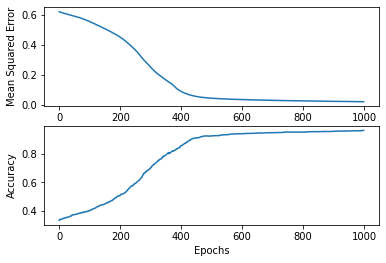


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.7375734135586725
Classification Report
                             
TP                        188
TN                        215
FP                          4
FN                          4
Total                     411
Accuracy   0.9805352798053528
Recall     0.9791666666666666
Precision  0.9791666666666666
Loss :  0.017191361322680895

Split 9 : 
Training the Model...


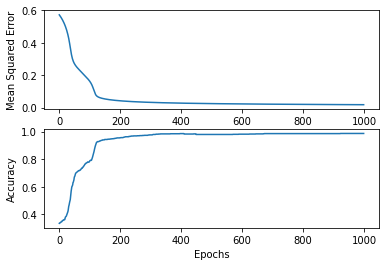


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.12914423681353157
Classification Report
                             
TP                        174
TN                        231
FP                          3
FN                          3
Total                     411
Accuracy   0.9854014598540146
Recall     0.9830508474576272
Precision  0.9830508474576272
Loss :  0.02419252291573717

Split 10 : 
Training the Model...


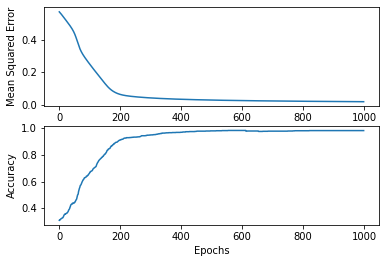


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.15400095885376502
Classification Report
                             
TP                        177
TN                        225
FP                          2
FN                          7
Total                     411
Accuracy   0.9781021897810219
Recall     0.9619565217391305
Precision  0.9888268156424581
Loss :  0.01738622521649361


Final Classification Report (Average Values across  10  splits)
                             
TP                      175.0
TN                      225.2
FP                        3.6
FN                        7.2
Total                   411.0
Accuracy   0.9737226277372264
Recall     0.9605393788929261
Precision  0.9795069394180729
Average Loss :  0.023497592092693243
Most important feature is 'attr 4 '


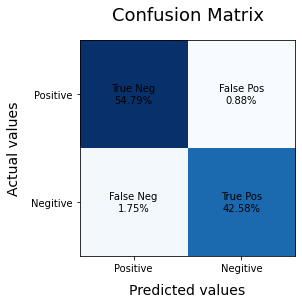

In [ ]:
GD1.train_k_splits(10, epochs=1000, learning_rate=0.1, printVal=False)

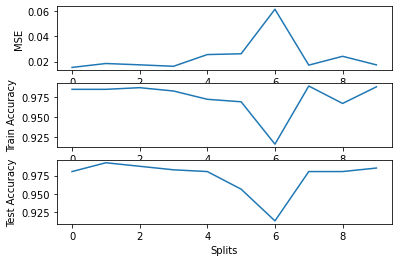

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(GD1.lossList[:10])
plt.xlabel('Splits')
plt.ylabel('MSE')

plt.subplot(3, 1, 2)
plt.plot(GD1.accuracyList[:10])
plt.xlabel('Splits')
plt.ylabel('Train Accuracy')

plt.subplot(3, 1, 3)
plt.plot(GD1.tAccuracy[:10])
plt.xlabel('Splits')
plt.ylabel('Test Accuracy')

plt.show()

### Learning Rate =0.5 and Epochs = 1000 - Accuracy = 99.09% - Standardized Data

In [ ]:
GD2 = LogReg(df, standardize=True)

Total of 10 Splits:

Split 1 : 
Training the Model...


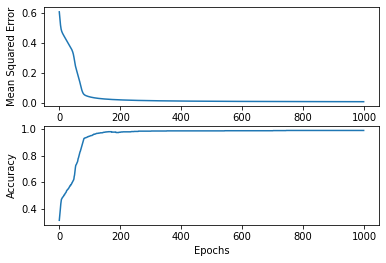


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.13406812586760133
Classification Report
                             
TP                        185
TN                        223
FP                          2
FN                          1
Total                     411
Accuracy   0.9927007299270073
Recall     0.9946236559139785
Precision  0.9893048128342246
Loss :  0.010867715879504431

Split 2 : 
Training the Model...


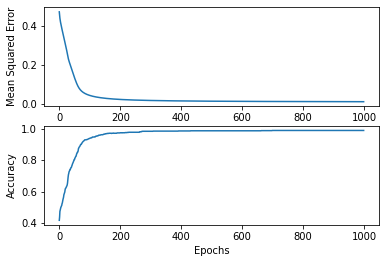


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.13727172871682458
Classification Report
                             
TP                        175
TN                        233
FP                          3
FN                          0
Total                     411
Accuracy   0.9927007299270073
Recall                    1.0
Precision  0.9831460674157303
Loss :  0.010270750905371488

Split 3 : 
Training the Model...


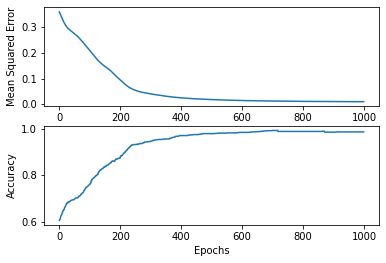


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.2114339058844875
Classification Report
                             
TP                        195
TN                        214
FP                          2
FN                          0
Total                     411
Accuracy   0.9951338199513382
Recall                    1.0
Precision  0.9898477157360406
Loss :  0.01045411765373876

Split 4 : 
Training the Model...


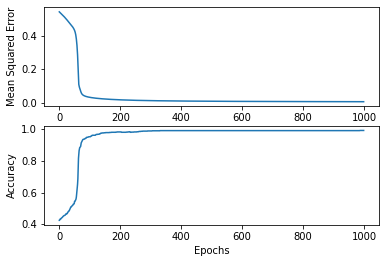


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.16084338134158785
Classification Report
                             
TP                        187
TN                        219
FP                          4
FN                          1
Total                     411
Accuracy   0.9878345498783455
Recall     0.9946808510638298
Precision  0.9790575916230366
Loss :  0.009374124385047884

Split 5 : 
Training the Model...


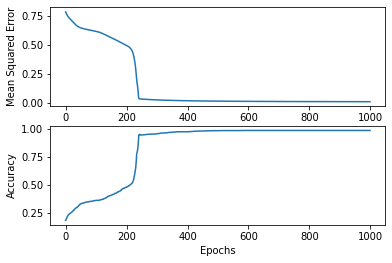


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.19288086095579376
Classification Report
                             
TP                        183
TN                        223
FP                          3
FN                          2
Total                     411
Accuracy   0.9878345498783455
Recall     0.9891891891891892
Precision  0.9838709677419355
Loss :  0.01001679412700841

Split 6 : 
Training the Model...


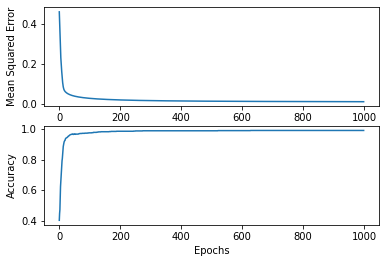


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.12097116417725921
Classification Report
                             
TP                        170
TN                        237
FP                          3
FN                          1
Total                     411
Accuracy   0.9902676399026764
Recall     0.9941520467836257
Precision  0.9826589595375722
Loss :  0.010071078312550637

Split 7 : 
Training the Model...


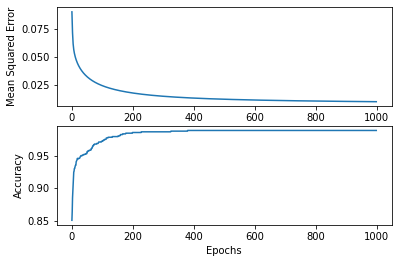


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.1106706072495352
Classification Report
                             
TP                        187
TN                        219
FP                          2
FN                          3
Total                     411
Accuracy   0.9878345498783455
Recall     0.9842105263157894
Precision  0.9894179894179894
Loss :  0.010027701893469914

Split 8 : 
Training the Model...


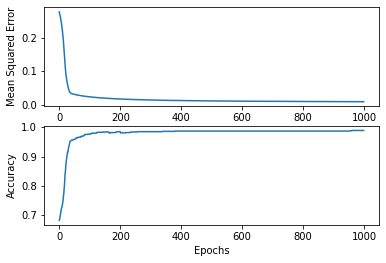


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.04732359374873668
Classification Report
                             
TP                        191
TN                        216
FP                          2
FN                          2
Total                     411
Accuracy   0.9902676399026764
Recall     0.9896373056994818
Precision  0.9896373056994818
Loss :  0.009465104927146561

Split 9 : 
Training the Model...


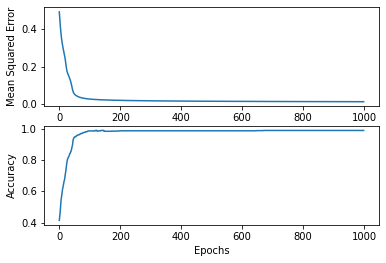


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.06062494746373196
Classification Report
                             
TP                        184
TN                        225
FP                          1
FN                          1
Total                     411
Accuracy   0.9951338199513382
Recall     0.9945945945945946
Precision  0.9945945945945946
Loss :  0.010651904822836043

Split 10 : 
Training the Model...


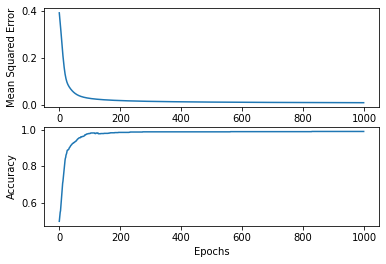


Trained the Model.

The most important feature is 'attr 4 ' with weight -0.12348126769982215
Classification Report
                             
TP                        168
TN                        239
FP                          2
FN                          2
Total                     411
Accuracy   0.9902676399026764
Recall     0.9882352941176471
Precision  0.9882352941176471
Loss :  0.01063140938458348


Final Classification Report (Average Values across  10  splits)
                             
TP                      182.5
TN                      224.8
FP                        2.4
FN                        1.3
Total                   411.0
Accuracy   0.9909975669099756
Recall     0.9929323463678136
Precision  0.9869771298718252
Average Loss :  0.01018307022912576
Most important feature is 'attr 4 '


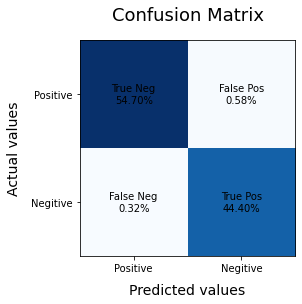

In [ ]:
GD2.train_k_splits(10, epochs=1000, learning_rate=0.5, printVal=False)

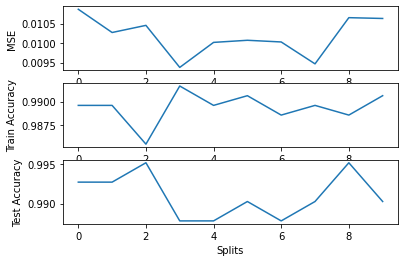

In [ ]:
plt.subplot(3, 1, 1)
plt.plot(GD2.lossList[:10])
plt.xlabel('Splits')
plt.ylabel('MSE')

plt.subplot(3, 1, 2)
plt.plot(GD2.accuracyList[:10])
plt.xlabel('Splits')
plt.ylabel('Train Accuracy')

plt.subplot(3, 1, 3)
plt.plot(GD2.tAccuracy[:10])
plt.xlabel('Splits')
plt.ylabel('Test Accuracy')

plt.show()

## Stochastic Gradient Descent

Gradient Descent gives us the accurate minima, by converging at the local/global minima of the loss, but it takes a long time to iterate over all the data points in each epoch. Therefore, in practice people prefer using **Stochastic Gradient Descent**

In **Stochastic Gradient Descent**, we randomly pick a data point and update the weights based on only that data point in each epoch. 

This variant of learning takes place slower, but it is proven that this method of learning always converges to a range of values around the minima. This range is called the **Region of Confusion** (From the perspective of data science, having a small margin of error from the original value is desired, and this method of learning will assure that).


Each update is given by the below, where the data point $x_{n}$ is choosen randomly in each epoch:
 - $w^{\tau + 1} = w^{\tau} + \eta.▽(\sigma(w^{T}\phi(x_{n})))$, 
    - where $\\eta$ is the learning rate,
    - ${w}$ is the weight matrix.
    - $\\phi(x_{n})$ is the transformed feature of the nth data point.
    - The value of the gradient/partial derivative (▽) is given by:
        - $(\hat{y} - y).\hat{y}.(1-\hat{y})$
        , here $\hat{y}=\sigma(w^{T}\phi(x_{n})) = \frac{1}{1+e^{-w^{T}\phi(x_{n})}}$



The above model has been trained on the learning rates 0.015, 0.1, and 0.5, using Stochastic Gradient Descent.

We have not normalized the datasets in SGD learning, as it was showing very poor results.

### Learning Rate = 0.015 and Epochs = 2000 - Accuracy = 94.40% - Not Standardized

Training the model using the final split of 'GD' training.

Epoch: 0 Loss: 0.21368036009882604 Accuracy: 0.6958333333333333
Epoch: 50 Loss: 0.1832062079565181 Accuracy: 0.740625
Epoch: 100 Loss: 0.1595675007518148 Accuracy: 0.775
Epoch: 150 Loss: 0.1324569211397593 Accuracy: 0.7989583333333333
Epoch: 200 Loss: 0.1167853688937097 Accuracy: 0.81875
Epoch: 250 Loss: 0.10705903318824565 Accuracy: 0.8375
Epoch: 300 Loss: 0.0970661081055017 Accuracy: 0.8520833333333333
Epoch: 350 Loss: 0.08844737544137667 Accuracy: 0.8614583333333333
Epoch: 400 Loss: 0.08229997827703081 Accuracy: 0.86875
Epoch: 450 Loss: 0.07229927739717916 Accuracy: 0.8916666666666667
Epoch: 500 Loss: 0.06785256613045934 Accuracy: 0.9010416666666666
Epoch: 550 Loss: 0.06510706132716004 Accuracy: 0.9052083333333333
Epoch: 600 Loss: 0.06371544693701403 Accuracy: 0.90625
Epoch: 650 Loss: 0.06161872025486293 Accuracy: 0.9104166666666667
Epoch: 700 Loss: 0.058888911724619304 Accuracy: 0.9166666666666666
Epoch: 750 Loss: 0.05897991076858446 Accuracy: 0.9125
Epoch: 800 Loss: 0.055210032091

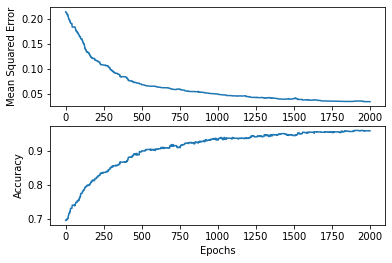

In [ ]:
GD.fit(GD.X_train, GD.y_train ,learning='SGD', intialize = True, epochs=2000, learning_rate=0.015, display_loss=True)

Classification Report
                             
TP                        170
TN                        218
FP                         10
FN                         13
Total                     411
Accuracy   0.9440389294403893
Recall     0.9289617486338798
Precision  0.9444444444444444


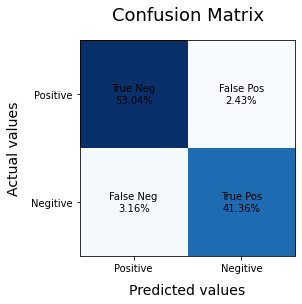

Loss :  0.03395592476659975
Most important feature is 'attr 4 '


In [ ]:
GD.evaluate(GD.X_test, GD.y_test)
print('Loss : ', GD.lossList[-1])
print('Most important feature is \'attr', np.argmax(np.bincount(GD.attrList)), '\'')

### Learning Rate = 0.1 and Epochs = 2000 - Accuracy = 98.54% - Not Standardized

In [ ]:
SGD1=LogReg(df)

Epoch: 0 Loss: 0.41933161639624866 Accuracy: 0.3927083333333333
Epoch: 50 Loss: 0.1795303125135905 Accuracy: 0.734375
Epoch: 100 Loss: 0.13438193914281935 Accuracy: 0.7947916666666667
Epoch: 150 Loss: 0.09791522054896111 Accuracy: 0.8583333333333333
Epoch: 200 Loss: 0.060538392288145074 Accuracy: 0.921875
Epoch: 250 Loss: 0.04961337705585591 Accuracy: 0.9333333333333333
Epoch: 300 Loss: 0.04084194758017154 Accuracy: 0.953125
Epoch: 350 Loss: 0.03979722153445916 Accuracy: 0.9510416666666667
Epoch: 400 Loss: 0.03437458182151055 Accuracy: 0.9572916666666667
Epoch: 450 Loss: 0.03173766560167383 Accuracy: 0.9604166666666667
Epoch: 500 Loss: 0.032415975699697064 Accuracy: 0.9666666666666667
Epoch: 550 Loss: 0.02754941289844272 Accuracy: 0.971875
Epoch: 600 Loss: 0.025978054108154857 Accuracy: 0.975
Epoch: 650 Loss: 0.0237930907260878 Accuracy: 0.9770833333333333
Epoch: 700 Loss: 0.029625243828084895 Accuracy: 0.9729166666666667
Epoch: 750 Loss: 0.023200675399779925 Accuracy: 0.975
Epoch: 800

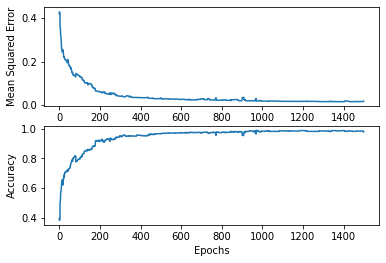

In [ ]:
SGD1.fit(SGD1.X_train, SGD1.y_train ,learning='SGD', intialize = True, epochs=1500, learning_rate=0.1, display_loss=True)

In [ ]:
print('Train Accuracy :', SGD1.accuracyList[-1])

Train Accuracy : 0.9791666666666666


Classification Report
                             
TP                        183
TN                        222
FP                          6
FN                          0
Total                     411
Accuracy   0.9854014598540146
Recall                    1.0
Precision  0.9682539682539683


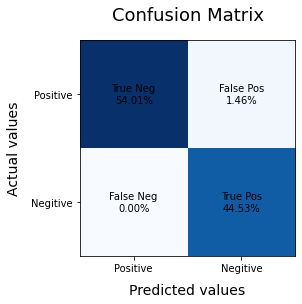

Loss :  0.017974918178084647
Most important feature is 'attr 4 '


In [ ]:
SGD1.evaluate(SGD1.X_test, SGD1.y_test)
print('Loss : ', SGD1.lossList[-1])
print('Most important feature is \'attr', SGD1.attrList[-1], '\'')

### Learning Rate = 0.5 and Epochs = 1500 - Accuracy = 99.51% - Not Standardized

In [ ]:
SGD=LogReg(df)

Epoch: 0 Loss: 0.4203536758111036 Accuracy: 0.49166666666666664
Epoch: 50 Loss: 0.07893311897052621 Accuracy: 0.8864583333333333
Epoch: 100 Loss: 0.03748846088532327 Accuracy: 0.94375
Epoch: 150 Loss: 0.1302077040434275 Accuracy: 0.8302083333333333
Epoch: 200 Loss: 0.03509026183255306 Accuracy: 0.9541666666666667
Epoch: 250 Loss: 0.0488380080220046 Accuracy: 0.9333333333333333
Epoch: 300 Loss: 0.04128196849060785 Accuracy: 0.946875
Epoch: 350 Loss: 0.01669608738849062 Accuracy: 0.98125
Epoch: 400 Loss: 0.10756373418567451 Accuracy: 0.871875
Epoch: 450 Loss: 0.03507384040245346 Accuracy: 0.9583333333333334
Epoch: 500 Loss: 0.036159558704515364 Accuracy: 0.9541666666666667
Epoch: 550 Loss: 0.016016106729831555 Accuracy: 0.978125
Epoch: 600 Loss: 0.04898172405255271 Accuracy: 0.9395833333333333
Epoch: 650 Loss: 0.023895728518742165 Accuracy: 0.971875
Epoch: 700 Loss: 0.07427691924920686 Accuracy: 0.909375
Epoch: 750 Loss: 0.05581739353565034 Accuracy: 0.93125
Epoch: 800 Loss: 0.0252953996

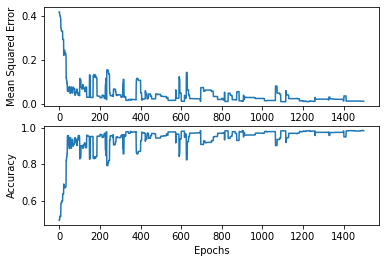

In [ ]:
SGD.fit(SGD.X_train, SGD.y_train ,learning='SGD', intialize = True, epochs=1500, learning_rate=0.5, display_loss=True)

In [ ]:
print('Train Accuracy :', SGD.accuracyList[-1])

Train Accuracy : 0.984375


Classification Report
                             
TP                        178
TN                        231
FP                          2
FN                          0
Total                     411
Accuracy   0.9951338199513382
Recall                    1.0
Precision  0.9888888888888889


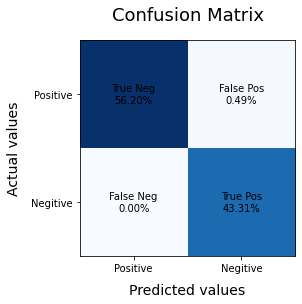

Loss :  0.01228070104107874
Most important feature is 'attr 4 '


In [ ]:
SGD.evaluate(SGD.X_test, SGD.y_test)
print('Loss : ', SGD.lossList[-1])
print('Most important feature is \'attr', SGD.attrList[-1], '\'')

### MBSGD with batch size=10

Mini Batch Gradient Descent is a mix of regular Gradient Descent and Stochastic Gradient Deascent

In [ ]:
trial1= LogReg(df, standardize=True)

Epoch: 0 Loss: 0.08988248878688496 Accuracy: 0.8958333333333334
Epoch: 50 Loss: 0.017886891445418416 Accuracy: 0.9770833333333333
Epoch: 100 Loss: 0.014775781981353573 Accuracy: 0.978125



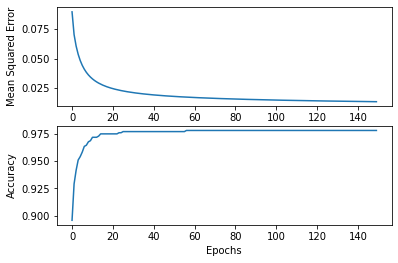

In [ ]:
#trial1.cross_val(10, learning='MBSGD', epochs=150, learning_rate=0.015, batch_size=1)
trial1.fit(trial1.X_train, trial1.y_train ,learning='MBSGD', intialize = True, epochs=150, learning_rate=0.015, display_loss=True)

Classification Report
                             
TP                        102
TN                        226
FP                          0
FN                         83
Total                     411
Accuracy   0.7980535279805353
Recall     0.5513513513513514
Precision                 1.0


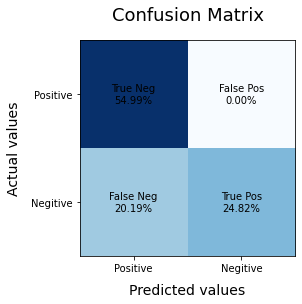

In [ ]:
trial1.evaluate(trial1.X_test, trial1.y_test)

# Trial

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression

le = LabelEncoder()
tr = df
tr['class'] = le.fit_transform(tr['class'])
tr.head()

tr = shuffle(tr)
X = tr.values[:,1:-1]
Y = tr.values[:,-1]

average= {}
maxm= {}

pipeLR = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])
lr_scores = cross_validate(pipeLR,X,Y,cv=7,return_train_score=True)
for i,(score, scoret) in enumerate(zip(lr_scores['test_score'],lr_scores['train_score'])):
    print("Fold ",i+1)
    print("Testing Accuracy = ",score," Training Accuracy = ",scoret)

average['Logistic Regression']=np.average(lr_scores['test_score'])
maxm['Logistic Regression']=np.amax(lr_scores['test_score'])
print("\nAverage test accuracy= ",average['Logistic Regression'],"\n")

lr_prec = cross_validate(pipeLR,X,Y,cv=7,scoring='precision')
for i,score in enumerate(lr_prec['test_score']):
    print("Precision over fold ",i+1," = ",score)
print("\n")
lr_rec = cross_validate(pipeLR,X,Y,cv=7,scoring='recall')
for i,score in enumerate(lr_rec['test_score']):
    print("Recall over fold ",i+1," = ",score)

Fold  1
Testing Accuracy =  0.7857142857142857  Training Accuracy =  0.8112244897959183
Fold  2
Testing Accuracy =  0.8061224489795918  Training Accuracy =  0.8078231292517006
Fold  3
Testing Accuracy =  0.8469387755102041  Training Accuracy =  0.8010204081632653
Fold  4
Testing Accuracy =  0.7704081632653061  Training Accuracy =  0.8137755102040817
Fold  5
Testing Accuracy =  0.7908163265306123  Training Accuracy =  0.8095238095238095
Fold  6
Testing Accuracy =  0.8316326530612245  Training Accuracy =  0.8035714285714286
Fold  7
Testing Accuracy =  0.7959183673469388  Training Accuracy =  0.8095238095238095

Average test accuracy=  0.8039358600583091 

Precision over fold  1  =  0.7446808510638298
Precision over fold  2  =  0.7578947368421053
Precision over fold  3  =  0.7938144329896907
Precision over fold  4  =  0.723404255319149
Precision over fold  5  =  0.7395833333333334
Precision over fold  6  =  0.8
Precision over fold  7  =  0.7764705882352941


Recall over fold  1  =  0.7954